In [77]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.models import RGCN_v1, gwnet_wrapper
from utils.xai_utils import integrated_gradients

plt.style.use('dark_background')
np.random.seed(123)
torch.manual_seed(123)

# Set up general arguments and pull in some real River-dl data

In [78]:
## Define some general arguments for the notebook
mod = 'GWN'  #GWN or RGCN
base = 'mean' #zeros or mean
grad_steps = 5 #Number of steps to take in calculation of IG
year_index = -1 #Sequence to apply IG to
weights_file = '../../river-dl/results/baseline/GWN/rep_5/finetuned_weights.pth'
prepped_file = "../../river-dl/results/baseline/GWN/prepped.npz"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pred_length = 15

river_dl = np.load(prepped_file)
num_vars = len(river_dl['x_vars'])
seq_len = river_dl['x_trn'].shape[1]
adj_matrix = river_dl['dist_matrix']
n_segs = adj_matrix.shape[0]

if base == 'zeros':
    x = torch.from_numpy(river_dl['x_trn']).float()[455*year_index:]
    baseline = torch.zeros_like(x)

elif base == 'mean':
    x = torch.from_numpy(river_dl['x_trn']).float()
    n_series = river_dl['x_trn'].shape[0]
    baseline = x.reshape(n_series//n_segs,n_segs,seq_len,num_vars)
    baseline = torch.mean(baseline,dim=0)
    x = x[455*year_index:]

dates_x = river_dl['times_trn'][455*year_index:][0].flatten()


x.shape,baseline.shape, adj_matrix.shape

(torch.Size([455, 60, 7]), torch.Size([455, 60, 7]), (455, 455))

In [79]:
if mod == 'RGCN':
    model = RGCN_v1(num_vars, 20, adj_matrix)
    model.load_state_dict(torch.load(weights_file, map_location=device))

elif mod == 'GWN':
    supports = [torch.tensor(adj_matrix).to(device).float()]
    out_dim = pred_length
    model = gwnet_wrapper(device,n_segs,supports=supports,aptinit=supports[0],
    in_dim=num_vars,out_dim=out_dim,layers=3, kernel_size=5,blocks=3, weights_path=weights_file,
                          nsegs=n_segs)

Text(0.5, 1.0, 'Integrated gradient values at one segment\nw.r.t. outputs at all space and time')

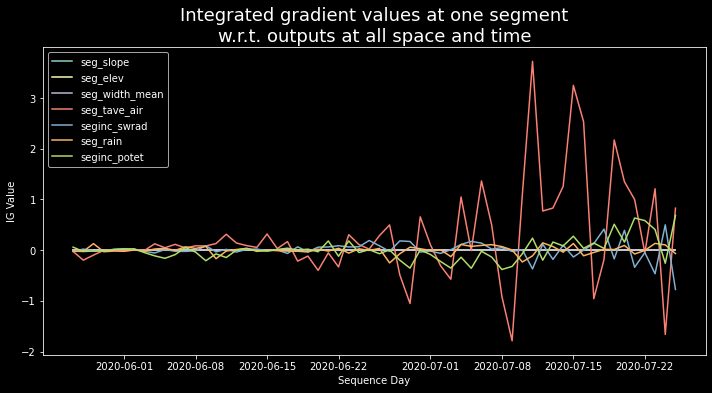

In [80]:
IG_vals = integrated_gradients(x, model, n_steps=grad_steps, baseline_x=baseline)

plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, IG_vals[0, :, i], label = river_dl['x_vars'][i])
plt.legend(loc = 'upper left')
plt.xlabel('Sequence Day')
plt.ylabel('IG Value')
plt.tight_layout()
plt.title('Integrated gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18)


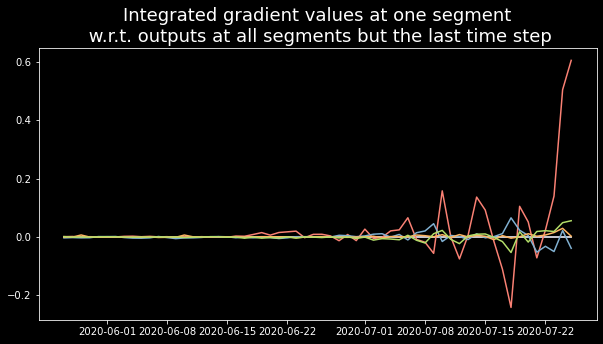

In [81]:
IG_vals = integrated_gradients(x,model, n_steps=grad_steps, baseline_x=baseline, temporal_focus = -1)

plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, IG_vals[0, :, i])
plt.title('Integrated gradient values at one segment\n w.r.t. outputs at all segments but the last time step',
          fontsize = 18);

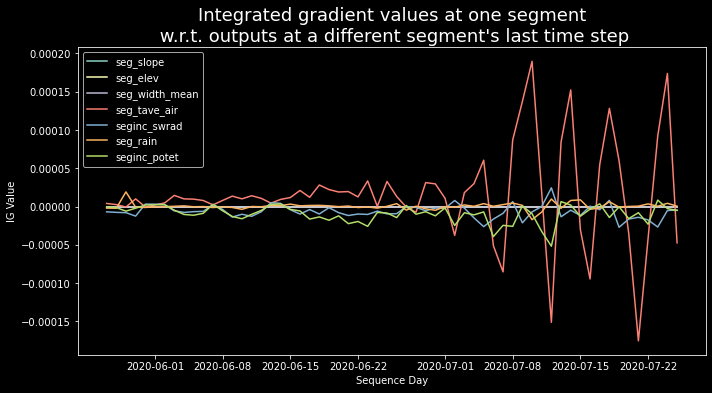

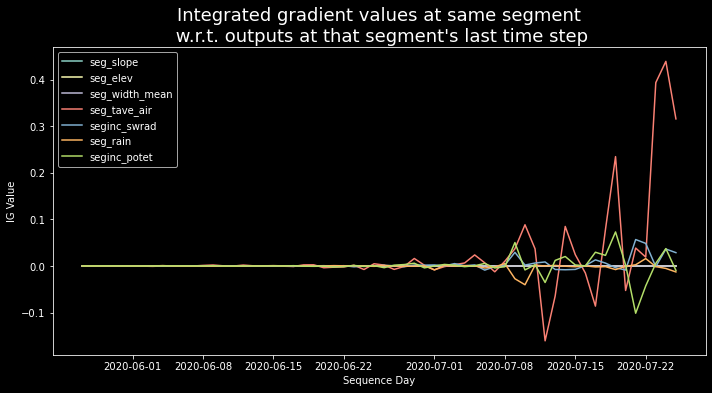

In [82]:
IG_vals = integrated_gradients(x,  model, n_steps=grad_steps, baseline_x=baseline, temporal_focus = -1, spatial_focus = -1)

plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, IG_vals[0, :, i],label = river_dl['x_vars'][i])
plt.legend(loc ='upper left')
plt.xlabel('Sequence Day')
plt.ylabel('IG Value')
plt.tight_layout()
plt.title("Integrated gradient values at one segment\n w.r.t. outputs at a different segment's last time step",
          fontsize = 18);

plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, IG_vals[-1, :, i],label = river_dl['x_vars'][i])
plt.legend(loc = 'upper left')
plt.xlabel('Sequence Day')
plt.ylabel('IG Value')
plt.tight_layout()
plt.title("Integrated gradient values at same segment\n w.r.t. outputs at that segment's last time step",
          fontsize = 18);

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

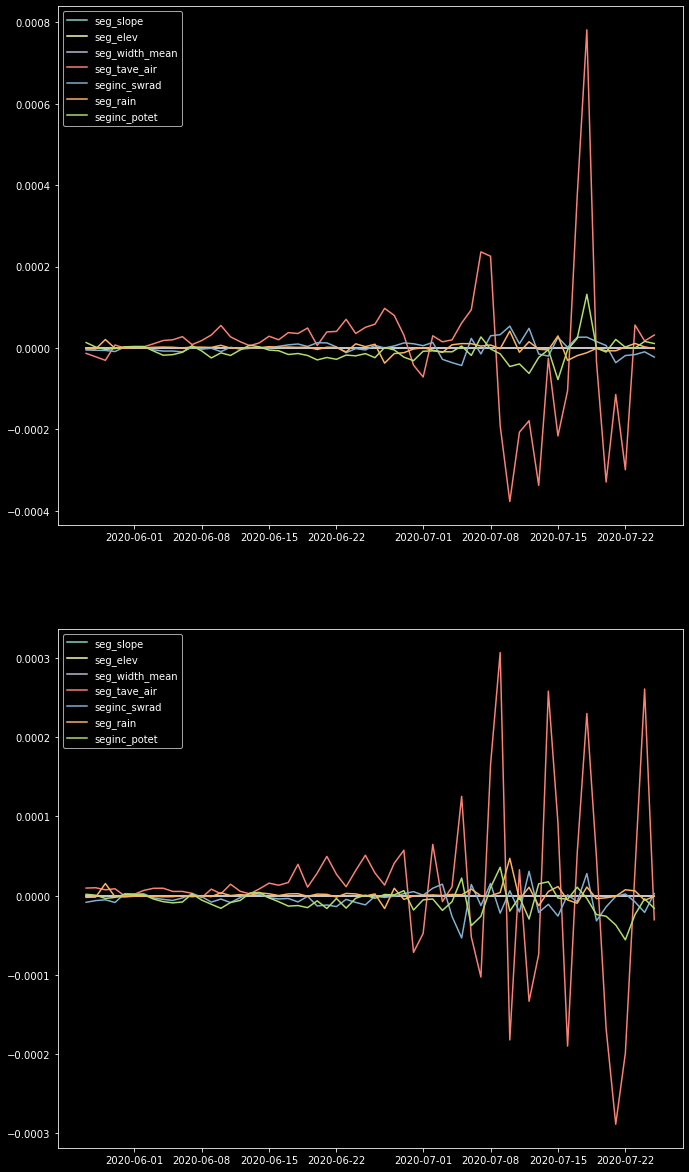

In [88]:
obs = range(1,pred_length, 7)
num_plots = len(obs)

fig, axes = plt.subplots(nrows=num_plots,figsize=(11.2,21))
for (ob,ax) in zip(reversed(obs),axes):
    attributions = integrated_gradients(x,model, n_steps=grad_steps, baseline_x=baseline, temporal_focus = -ob, spatial_focus = -1) # attributions for last day in the sequence
    for i in range(num_vars):
        ax.plot(dates_x,attributions[0, :, i], label = river_dl['x_vars'][i])
    ax.legend(loc = 'upper left')
plt.tight_layout


# Apply XAI and visualize - can we trust IG temporally?

When looking at what's important for the last time step's prediction, it appears that anything before the last 45 values don't matter. Let's do an experiment where we scramble those supposedly irrelevant values and see how it impacts predictions

In [89]:
IG_vals = integrated_gradients(x,  model, n_steps=grad_steps, baseline_x=baseline, temporal_focus = -1)

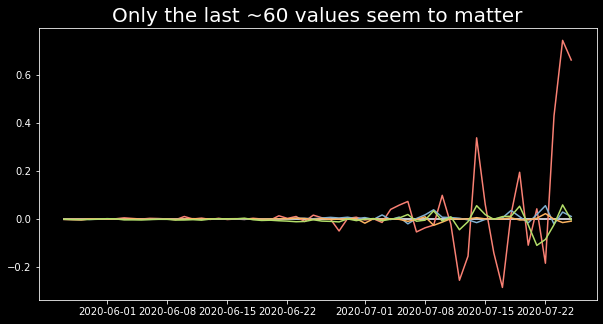

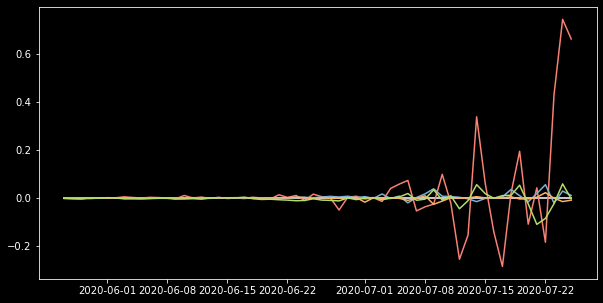

In [90]:
plt.figure(figsize = (10, 5))
plt.plot(dates_x, IG_vals[-1, :, :])
plt.title('Only the last ~60 values seem to matter', fontsize = 20)
plt.pause(0.001)
plt.figure(figsize = (10, 5))
plt.plot(dates_x[-60:], IG_vals[-1, -60:, :]);

In [91]:
 def compare_temporally_altered(first_n_days):
    y_hat_original = model(x)

    # replace first n out of 365 days with random values
    # and see how results change
    x_hypothesis = x.detach().clone()
    x_hypothesis[:, :first_n_days] = torch.rand_like(x[:, :first_n_days])
    y_hat_hypothesis = model(x_hypothesis)

    fig, ax = plt.subplots(3, 2, figsize = (12, 9))

    ax[0,0].plot(dates_x, x[0].detach(), color = 'white', alpha = 0.4)
    ax[0,0].set_ylim(-3, 5)
    ax[0,0].set_title('X Values')
    ax[0,1].plot(dates_x, x_hypothesis[0], color = 'white', alpha = 0.4)
    ax[0,1].set_ylim(-3, 5)
    ax[0,1].set_title('X Values Noised')
    ax[1,0].plot(y_hat_original[0].detach())
    ax[1,0].set_ylim(-1.5, 1.5)
    ax[1,0].set_title('Predicted Values')
    ax[1,1].plot(y_hat_hypothesis[0].detach())
    ax[1,1].set_ylim(-1.5, 1.5)
    ax[1,1].set_title('Predicted Noised')
    ax[2,0].plot(y_hat_original[0, :].detach())
    ax[2,0].plot(y_hat_hypothesis[0, :].detach())
    ax[2,0].set_title('Before and After Noise')
    ax[2,1].plot(y_hat_original[0, -60:].detach())
    ax[2,1].plot(y_hat_hypothesis[0, -60:].detach())
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

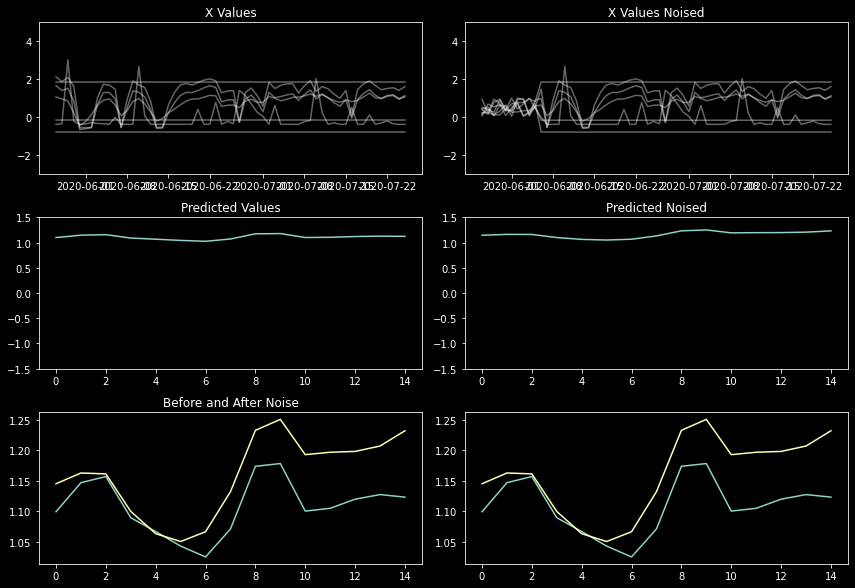

In [92]:
compare_temporally_altered(x.shape[1]-60)

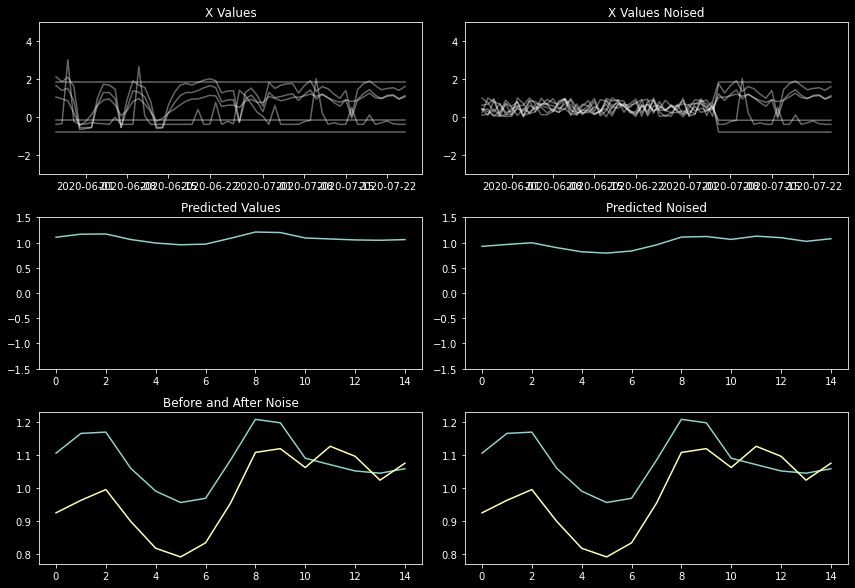

In [93]:
compare_temporally_altered(x.shape[1]-30)

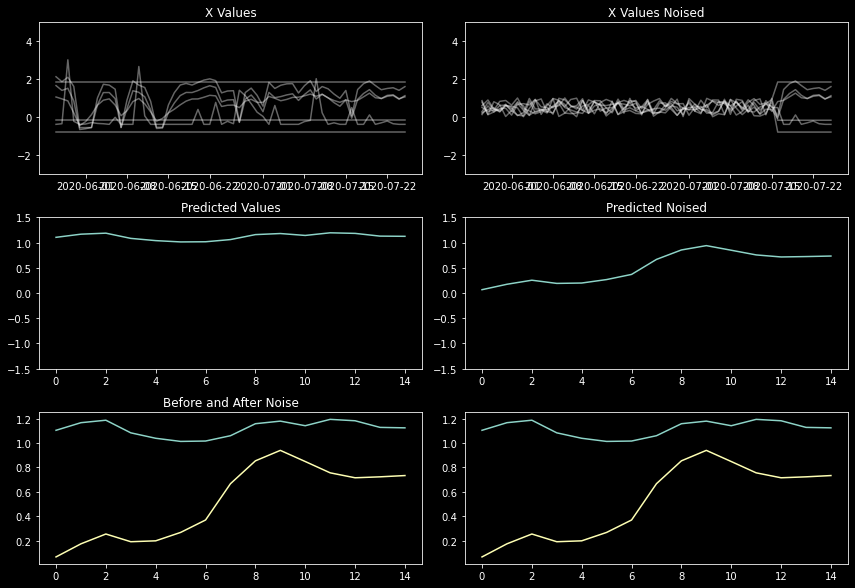

In [94]:
compare_temporally_altered(x.shape[1]-10)

The evidence appears to suggest that we can trust how IG explains importance temporally

# Apply XAI and visualize - can we trust IG spatially?

Similar experiment to the above, but seeing if we can trust what neighboring streams are identified as important

In [95]:
def compare_spatially_altered(seg_of_interest, important_segments, unimportant_segments):
    y_hat_original = model(x)

    x_hypothesis1 = x.detach().clone()
    for s in important_segments:
        x_hypothesis1[s] = torch.rand_like(x[s])
    y_hat_hypothesis1 = model(x_hypothesis1)
    
    x_hypothesis2 = x.detach().clone()
    for s in unimportant_segments:
        x_hypothesis2[s] = torch.rand_like(x[s])
    y_hat_hypothesis2 = model(x_hypothesis2)

    fig, ax = plt.subplots(5, figsize = (10, 30))

    for seg in important_segments:
        ax[0].plot(x[seg].detach(), color = 'white', alpha = 0.3)
        ax[1].plot(x_hypothesis1[seg], color = 'white', alpha = 0.5)
        ax[1].set_title('Changed segment variable values | important')
        
    for seg in unimportant_segments:
        ax[0].plot(x[seg].detach(), color = 'white', alpha = 0.3)
        ax[0].set_title('Unchanged segment variable')
        ax[2].plot(x_hypothesis2[seg], color = 'white', alpha = 0.5)
        ax[2].set_title('Changed segment variable values | unimportant')
    
    ax[3].set_title('Predictions under different scenarios')
    ax[3].plot(y_hat_original[seg_of_interest, :].detach(),
               label = 'Original')
    ax[3].plot(y_hat_hypothesis1[seg_of_interest, :].detach(),
               label = 'Important segments changed',
               linestyle = '--')
    ax[3].plot(y_hat_hypothesis2[seg_of_interest, :].detach(),
               label = 'Unimportant segments changed',
               linestyle = '--')
    ax[3].legend()
    
    ax[4].set_title('Difference in predictions')
    ax[4].plot(y_hat_original[seg_of_interest, :].detach() - y_hat_hypothesis1[seg_of_interest, :].detach(),
                 label = 'Important segments changed')
    ax[4].plot(y_hat_original[seg_of_interest, :].detach() - y_hat_hypothesis2[seg_of_interest, :].detach(),
                 label = 'Unimportant segments changed')
    ax[4].legend()

In [96]:
spatial_focus = np.random.choice(455)

IG_vals = integrated_gradients(x, model,baseline_x=baseline,n_steps=grad_steps, spatial_focus = spatial_focus)

most_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[1:5] # 1:5 because not itself
least_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[-5:]

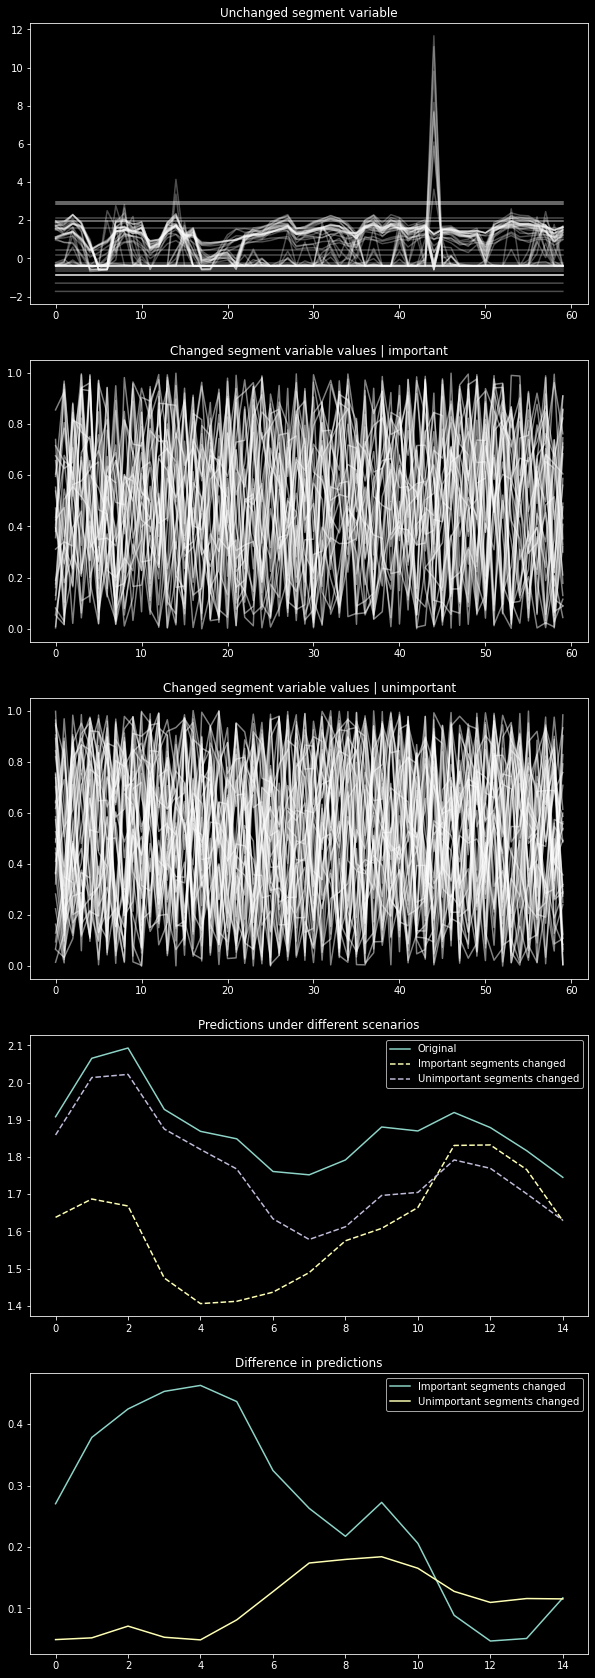

In [97]:
compare_spatially_altered(spatial_focus, most_relev, least_relev)

### A slightly more obvious difference in predictions

Spatial information doesn't seem to play a huge role, so hand-picking a more sensitive segment helps show the difference

In [98]:
spatial_focus = -1

IG_vals = integrated_gradients(x,  model,baseline_x=baseline,n_steps=grad_steps, temporal_focus = -1, spatial_focus = spatial_focus)

most_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[1:5] # 1:5 because not itself
least_relev = np.argsort(-np.sum(np.sum(np.abs(IG_vals), axis = 2), axis = 1))[-5:]

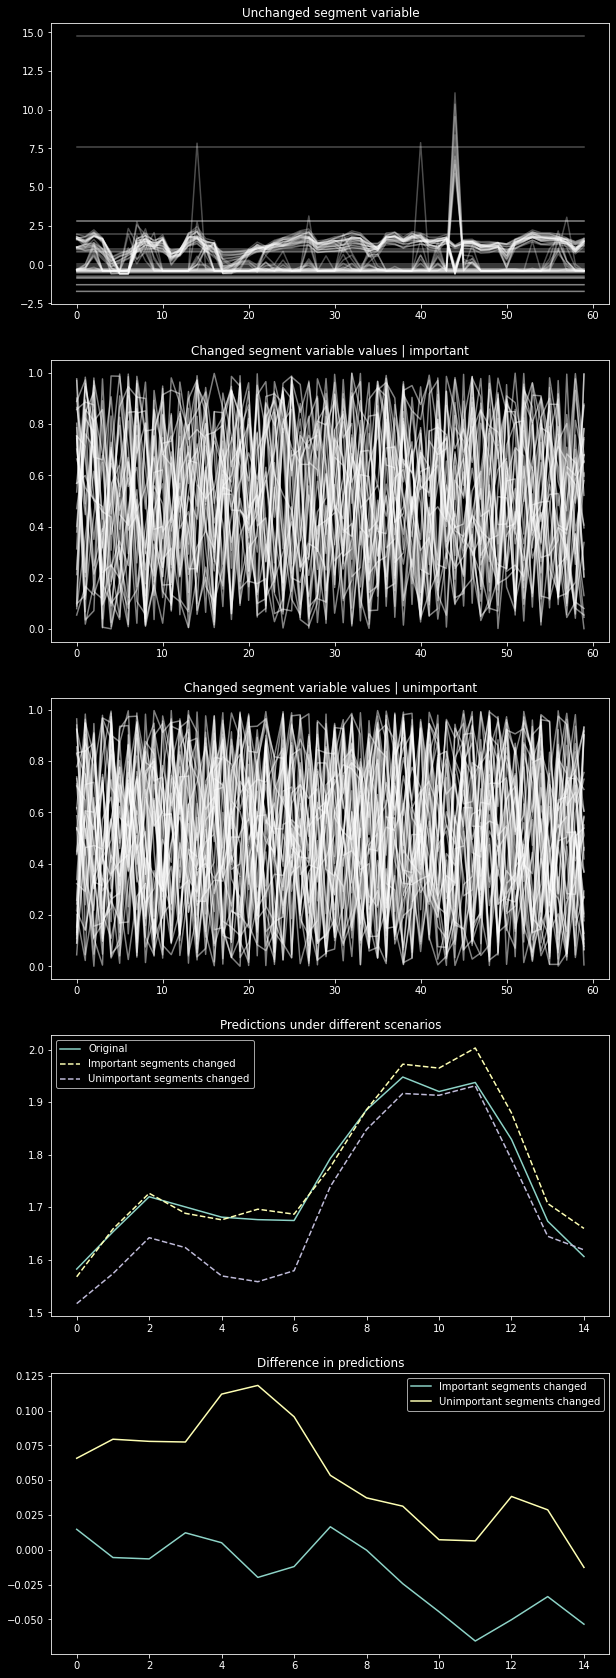

In [99]:
compare_spatially_altered(spatial_focus, most_relev, least_relev)

The evidence appears to suggest that we can trust how IG explains importance spatially

# Can we trust the feature importance?

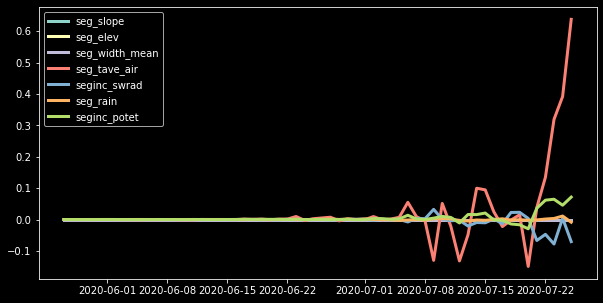

In [100]:
spatial_focus = 1 # has lots of observations

IG_vals = integrated_gradients(x, model, baseline_x=baseline,n_steps=grad_steps, temporal_focus = -1, spatial_focus = 1)

plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, IG_vals[spatial_focus, :, i], label = river_dl['x_vars'][i], linewidth = 3)
#plt.xlim(, 180)
plt.legend(loc = 'upper left');

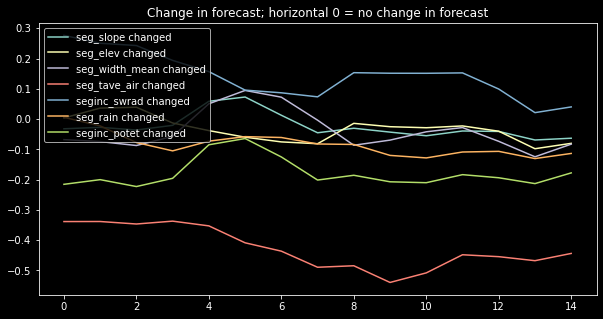

In [101]:
original_y_hat = model(x)

rmse_ls = []
plt.figure(figsize = (10, 5))

for i in range(num_vars):
    x_hypothesis = x.detach().clone()
    x_hypothesis[1, :, i] = torch.rand_like(x_hypothesis[1, :, i]) # change the variables
    
    y_hypothesis = model(x_hypothesis)
    
    plt.plot(y_hypothesis[1].detach() - original_y_hat[1].detach(), # view difference in forecast
             label = river_dl['x_vars'][i] + ' changed')
    #plt.xlim(80,180)
    plt.title('Change in forecast; horizontal 0 = no change in forecast')
    
plt.legend(loc = 'upper left');

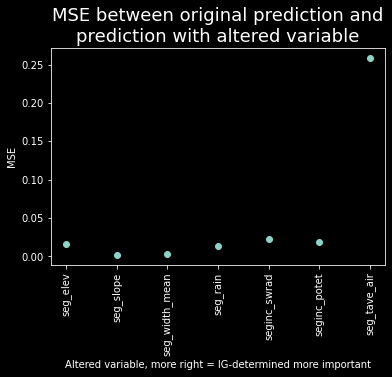

In [102]:
ordered_importance_of_vars = np.argsort(np.sum(np.abs(IG_vals[1]), axis = 0))

mse_ls = []
for var in ordered_importance_of_vars:
    x_hypothesis = x.detach().clone()
    x_hypothesis[1, :, var] = torch.rand_like(x_hypothesis[1, :, var])
    y_hypothesis = model(x_hypothesis)
    mse = torch.mean((y_hypothesis[1].detach() - original_y_hat[1].detach())**2).item()
    mse_ls.append(mse)
    
plt.scatter(range(len(mse_ls)), mse_ls)
plt.xticks(range(len(mse_ls)), labels = river_dl['x_vars'][ordered_importance_of_vars], rotation = 90)
plt.title('MSE between original prediction and\nprediction with altered variable', fontsize = 18)
plt.ylabel('MSE')
plt.xlabel('Altered variable, more right = IG-determined more important');

The experimental results line up pretty well (2 most important variables result in the most forecast change). Not entirely monotonic though, static features and 0-baseline could be playing a role